In [2]:
from pathlib import Path
import sys
import yaml
import time
import os
import copy

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib import lines

DIR = Path('..')
sys.path.insert(0, str(DIR))
from SCanalyzer import SCanalyzer
from SCanalyzer.busSim import BusSim, Config
from SCanalyzer.busSim.manager import managerFactory
from SCanalyzer.gtfs_edit import edit_double
from SCanalyzer.util import findEPSG
from pyproj import Transformer

import matplotlib.pyplot as plt
from matplotlib import lines

import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

from shapely import geometry

%matplotlib inline

manger init
mangager register
mangager register


In [3]:
def get_yelp_api_key():
    with open("../config.yml", 'r') as yml:
        cfg = yaml.safe_load(yml)
        return cfg["yelp"]["api_key"]

def plot_background(crs):
    background_path = os.path.join('..', 'data', 'plot', 'background')
    city = gpd.read_file(os.path.join(background_path, "madison-meter-shp")).to_crs(crs)
    lakes = gpd.read_file(os.path.join(background_path, "water-meter-shp")).to_crs(crs)
    street = gpd.read_file(os.path.join(background_path, "street-meter-shp")).to_crs(crs)
    # city = gpd.read_file(background_path + "madison-shp")
    # lakes = gpd.read_file(background_path + "water-shp")
    # street = gpd.read_file(background_path + "street-shp")

    ax = city.plot(color="lightgray", alpha=.2, figsize=(12, 12), zorder=2)
    lakes.plot(color="lightblue", ax=ax, zorder=1, alpha=0.8)
    street.plot(color="darkgray", alpha = .5, ax=ax, zorder=3)
    return ax

# route remove study

In [4]:
api_key = 'ZsHZFGtKEZeOOXhTne98eErmfd6BfNTm9GqO2S6inSnWzDwtgC2sEauXcB-8zUna_lXZEal4jsW_St6O0OQOcuNvifrr6uqNYmjFXW-FyVKvaMyczbihWELI80tjYHYx'
gtfo = SCanalyzer(os.path.join('..', 'data', 'minneapolist_gtfs.zip'))
census_gdf = gtfo.load_census()
services_gdf = gtfo.load_yelp(api_key=api_key)

stops_meter exists
Getting geodataframe for tracts from Tigerweb:
https://tigerweb.geo.census.gov/arcgis/rest/services/Generalized_ACS2019/Tracts_Blocks/MapServer/4/query?geometry=-10406328.01%2C5644272.76&geometryType=esriGeometryPoint&spatialRel=esriSpatialRelIntersects&distance=77222.14&units=esriSRUnit_Meter&outFields=STATE%2CCOUNTY%2CTRACT%2CBLKGRP&returnGeometry=true&returnTrueCurves=false&returnIdsOnly=false&returnCountOnly=false&returnZ=false&returnM=false&returnDistinctValues=false&returnExtentOnly=false&featureEncoding=esriDefault&f=geojson
Getting demographics data from Census.gov, this may take a couple minutes...


ConnectionError: ('Connection aborted.', TimeoutError(60, 'Operation timed out'))

In [1]:
census_gdf

NameError: name 'census_gdf' is not defined

In [4]:
services_gdf

,id,service,name,latitude,longitude
0,-o9rv1IHv5-MEoAEUgSSaA,banks,Bank West,45.087509,-93.735947
1,RVMdp6lpoFnuuhycP2tA3w,banks,TopLine Federal Credit Union,45.12519,-93.40344
2,P6zPCwfjhQSmK1-qyqSFCg,banks,Tcf Bank,45.198322,-93.38501
3,owZsCpnLwi0lCzVsUNreZg,banks,SPIRE Credit Union - Maple Grove,45.128046,-93.488595
4,E0f2H9AIz3-S3p5D109PkA,banks,Realize Financial Advisors,45.3033,-93.566334
...,...,...,...,...,...
94,9nz3g-kMk80f6cEF0LLxpA,supermarket,Solo Vino,44.946705,-93.122024
95,CMFEdxLaeYAI9Vf3NUQx4w,supermarket,The Herbivorous Butcher,44.990233,-93.253967
96,gpy5XrMcYX-KNETYF9ctTg,supermarket,El Burrito Mercado,44.929967,-93.077473
97,WlWRwxb5MNk1ZcmtiABvSA,supermarket,Penzeys Spices,44.947311,-93.298653


In [5]:
# routes = [ 2,  4,  5,  6,  7,  8, 10, 11, 12, 13, 15, 16, 17, 18, 20, 21, 22,
#        23, 26, 27, 30, 31, 32, 33, 36, 39, 40, 44, 48, 49, 50, 51, 52, 55,
#        67, 70, 72, 73, 75, 59, 63, 68, 78, 80, 84, 81, 82]

routes = [80]
for route in routes:
    print(route)
    gtfo.set_batch_label(f"{route}-rm")
    config = Config(day="monday", elapse_time="00:20:00", interval="08:00:00", max_walking_min=10, route_remove=[])
    config.set_starts(centroids=census_gdf)

    perf_df = pd.DataFrame(
            columns=["geometry", "start_time", "search_time", "add_service_time", "add_census_time"])
    result_gdf = gtfo.search(config, perf_df)
    gtfo.add_service_metrics(result_gdf, services_gdf, perf_df)
#     gtfo.add_demographic_metrics(result_gdf, census_gdf, perf_df)
    result_gdf.to_csv(os.path.join('.', 'out', f'result{route}.csv'), index=False)
    perf_df.to_csv(os.path.join('.', 'out', f'perf{route}.csv'), index=False)

80
get available manager
manager create
self=<SCanalyzer.busSim.manager.managerFactory.ManagerFactory object at 0x7f5346de1e80>
key='local'
manager=<class 'SCanalyzer.busSim.manager.localManager.LocalManager'>
Empty DataFrame
Columns: [geometry, start_time, search_time, add_service_time, add_census_time]
Index: []


100%|██████████| 1500/1500 [02:50<00:00,  8.82it/s]


In [6]:
def get_score(area, banks=0, clinics=0, dentists=0, hospitals=0, supermarkets=0):
    x6 = 1
    if banks == 0:
        x6 = x6/2
    if supermarkets == 0:
        x6 = x6/2
    if hospitals == 0:
        x6 = x6/2
    if clinics == 0:
        x6 = x6/2
    if dentists == 0:
        x6 = x6/2
    score = (area + banks + clinics + hospitals + dentists + supermarkets) * x6
    return score

<AxesSubplot:>

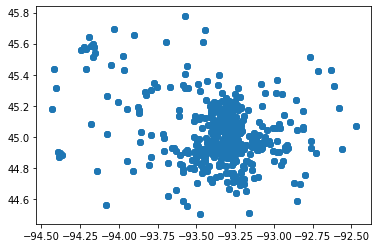

In [7]:
gpd.GeoSeries(result_gdf['geometry']).plot()

In [8]:
def plot_preferred_points(result_gdf, city_gpd=None):
    if city_gpd is None:
        polys = [[p.x, p.y] for p in result_gdf['geometry']]
        ax = gpd.GeoSeries(geometry.Polygon(polys).convex_hull).plot(color="lightgrey", alpha=0.5)
    else:
        ax = city_gpd.plot(color="grey", alpha=0.5)
    result_gdf['score'] = result_gdf.apply(axis=1, func=lambda row: get_score(0, row['banks'], row['clinics'], row['dentists'], row['hospitals'], row['supermarket']))
    results = result_gdf[result_gdf['score'] != 0].sort_values('score')
    points_low = results.head(10)
    points_high = results.tail(10)
    gpd.GeoSeries(points_low['geometry']).plot(ax=ax, color="red")
    gpd.GeoSeries(points_high['geometry']).plot(ax=ax, color="green")
    points = {"low": [(p.y, p.x) for p in points_low['geometry']],
    "high": [(p.y, p.x) for p in points_high['geometry']]}

    lineslist = []
    lineslist.append(lines.Line2D([],[],color="white", markerfacecolor = "red", marker = "o", markersize=10, label = "low score"))
    lineslist.append(lines.Line2D([],[],color="white", markerfacecolor = "green", marker = "o", markersize=10, label = "high score"))
    ax.legend(handles = lineslist, loc="upper left",prop={"size": 10})
    plt.axis("off")
    plt.savefig("Madison_startpoints.png", dpi=300, bbox_inches="tight")
    print(points)


In [9]:
city = gpd.read_file("../data/plot/background/madison-shp")
minneapolis = gpd.read_file("../data/minneapolis/minneapolis.shp")
lansing = gpd.read_file("../data/lansing/lansing.shp").to_crs(4326)
st_louis = gpd.read_file("../data/stlouis/stlouis.shp").to_crs(4326)

<AxesSubplot:>

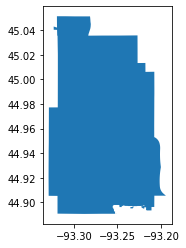

In [10]:
minneapolis.plot()

<AxesSubplot:>

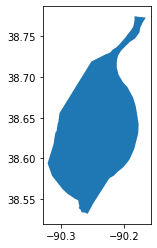

In [11]:
st_louis.plot()

{'low': [(44.820852518773165, -93.27007526760357), (45.03698099490727, -93.3273018807822), (45.07520646479199, -93.36447314869748), (45.14351172737558, -93.26887266443758), (45.01564156164276, -93.37466650992579), (45.07391882519973, -93.26580601973103), (45.04092052687533, -93.26546083324378), (44.84429728444731, -93.24484777443656), (44.90964204554468, -93.4073130057834), (44.99941607025379, -93.05624081015259)], 'high': [(44.96694574782479, -93.27932464626308), (44.9908438111097, -93.24767264600557), (44.96096525625919, -93.24283547951629), (44.964202774732755, -93.2647555237972), (44.96872234263041, -93.25058726230623), (44.976190237605174, -93.25424267826821), (44.976190237605174, -93.25424267826821), (44.973751479498084, -93.27271856402542), (44.96872234263041, -93.25058726230623), (44.973751479498084, -93.27271856402542)]}


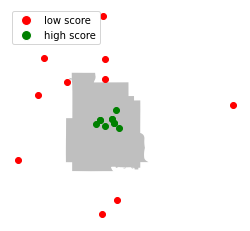

In [12]:
plot_preferred_points(result_gdf=result_gdf, city_gpd = minneapolis)

# route doubling study

In [8]:
print(perf_df)

                                          geometry start_time search_time  \
0     POINT (-89.65749071743502 43.12558522013633)     0:0:00     0.02079   
1         POINT (-89.58410468038977 42.9977144585)     0:0:00     0.01345   
2      POINT (-89.52480673380735 43.0440282770501)     0:0:00    0.014723   
3     POINT (-89.52461125108374 43.02680593102333)     0:0:00    0.013335   
4      POINT (-89.51016191651111 43.0479695906991)     0:0:00    0.013433   
...                                            ...        ...         ...   
2219   POINT (-89.2543335991909 43.17941696996946)    21:0:00    0.024533   
2220  POINT (-89.22025804318837 43.18544080303251)    21:0:00    0.023935   
2221  POINT (-89.23124966766352 43.05574718320674)    21:0:00    0.026493   
2222  POINT (-89.19161761144784 43.21318565393248)    21:0:00    0.019181   
2223  POINT (-89.19791660630933 42.98254107176306)    21:0:00    0.021153   

      add_service_time add_census_time  
0             0.007452            

In [9]:
sc = SCanalyzer(os.path.join('..', 'data', 'mmt_gtfs.zip'))
census_gdf = sc.load_census()
services_gdf = sc.load_yelp(api_key=api_key)
config = Config(day="monday", elapse_time="00:30:00", interval="2:10:00", max_walking_min=10)
config.set_starts(centroids=census_gdf)

routes = [ 2,  4,  5,  6,  7,  8, 10, 11, 12, 13, 15, 16, 17, 18, 20, 21, 22,
       23, 26, 27, 30, 31, 32, 33, 36, 39, 40, 44, 48, 49, 50, 51, 52, 55,
       67, 70, 72, 73, 75, 59, 63, 68, 78, 80, 84, 81, 82]
routes = [80]

result_folder = os.path.join('.', 'out', 'result')
perf_folder = os.path.join('.', 'out', 'perf')
if not os.path.exists(result_folder): os.makedirs(result_folder)
if not os.path.exists(perf_folder): os.makedirs(perf_folder)

for route in routes:
    print(route)
    sc.gtfs_edit(edit_double, route)
    sc.set_batch_label(f"{route}-double")
    perf_df = pd.DataFrame(
            columns=["geometry", "start_time", "search_time", "add_service_time", "add_census_time"])
    result_gdf = sc.search(config, perf_df)
    sc.add_service_metrics(result_gdf, services_gdf, perf_df)
    sc.add_demographic_metrics(result_gdf, census_gdf, perf_df)
    result_gdf.to_csv(os.path.join('.', 'out', 'result', f'result{route}-double.csv'), index=False)
    perf_df.to_csv(os.path.join('.', 'out', 'perf', f'perf{route}-double.csv'), index=False)
    break

stops_meter exists
80
get available manager
manager create
self=<SCanalyzer.busSim.manager.managerFactory.ManagerFactory object at 0x7f4824093a60>
key='local'
manager=<class 'SCanalyzer.busSim.manager.localManager.LocalManager'>
Empty DataFrame
Columns: [geometry, start_time, search_time, add_service_time, add_census_time]
Index: []


100%|██████████| 3058/3058 [02:39<00:00, 19.14it/s]


In [10]:
sc = SCanalyzer(os.path.join('..', 'data', 'mmt_gtfs.zip'))
census_gdf = sc.load_census()
config = Config(day="monday", elapse_time="00:30:00", interval="10:00:00", max_walking_min=10)
# config.set_starts(points=[(43.073691, -89.387407), (43.073691, -89.387407)])
config.set_starts(centroids=census_gdf)
t0 = time.time()
result_gdf = sc.search(config)
t1 = time.time()
print(t1-t0)

services_gdf = sc.load_yelp(api_key=api_key)
sc.add_service_metrics(result_gdf, services_gdf)
t2 = time.time()
print(t2-t1)

sc.add_demographic_metrics(result_gdf, census_gdf) # SLOW
t3 = time.time()
print(t3-t2)
result_gdf["banks"].sum() #7263.0

stops_meter exists
get available manager
manager create
self=<SCanalyzer.busSim.manager.managerFactory.ManagerFactory object at 0x7f4824093a60>
key='local'
manager=<class 'SCanalyzer.busSim.manager.localManager.LocalManager'>
None


100%|██████████| 834/834 [00:29<00:00, 28.32it/s] 


29.48251748085022
6.720560312271118
3.5225768089294434


4894.0

In [11]:
sc.gtfs_edit(edit_double, 80)
t0 = time.time()
result_gdf = sc.search(config)
t1 = time.time()
print(t1-t0)

services_gdf = sc.load_yelp(api_key=api_key)
sc.add_service_metrics(result_gdf, services_gdf)
t2 = time.time()
print(t2-t1)

sc.add_demographic_metrics(result_gdf, census_gdf) # SLOW
t3 = time.time()
print(t3-t2)
result_gdf["banks"].sum() #7263.0

get available manager
manager create
self=<SCanalyzer.busSim.manager.managerFactory.ManagerFactory object at 0x7f4824093a60>
key='local'
manager=<class 'SCanalyzer.busSim.manager.localManager.LocalManager'>
None


100%|██████████| 834/834 [00:34<00:00, 24.20it/s] 


34.49112296104431
6.945433139801025
3.7138445377349854


4898.0

In [12]:
result = pd.read_csv(os.path.join('.', 'out', 'result', 'result80-double.csv'))
result["banks"].sum()

20857.0

# Visualize simulation

stops_meter exists


<AxesSubplot:>

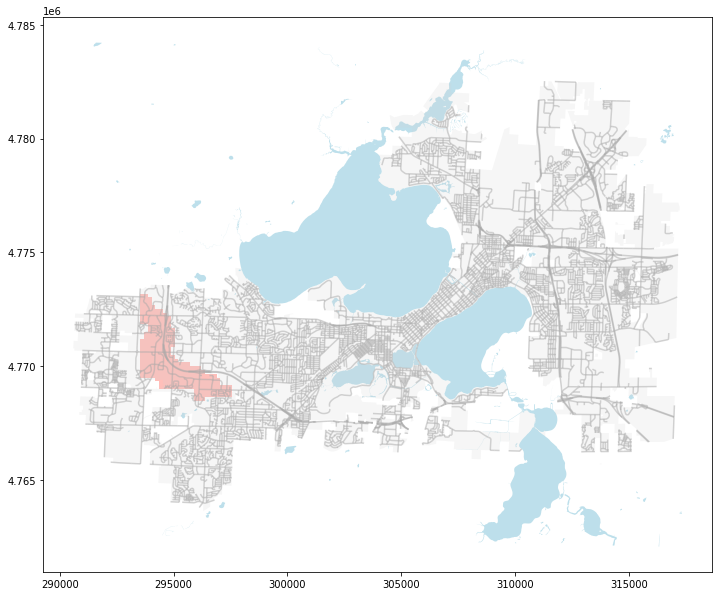

In [18]:
gtfo = SCanalyzer(os.path.join('..', 'data', 'mmt_gtfs.zip'))
ax = plot_background(f"EPSG:{gtfo.epsg}")
gtfo.set_batch_label(f"80-rm")
example_gdf = gtfo.load_result_map(map_identifier="search-result-0-360!4")
example_gdf.plot(color="#ffbfba", ax=ax)

stops_meter exists


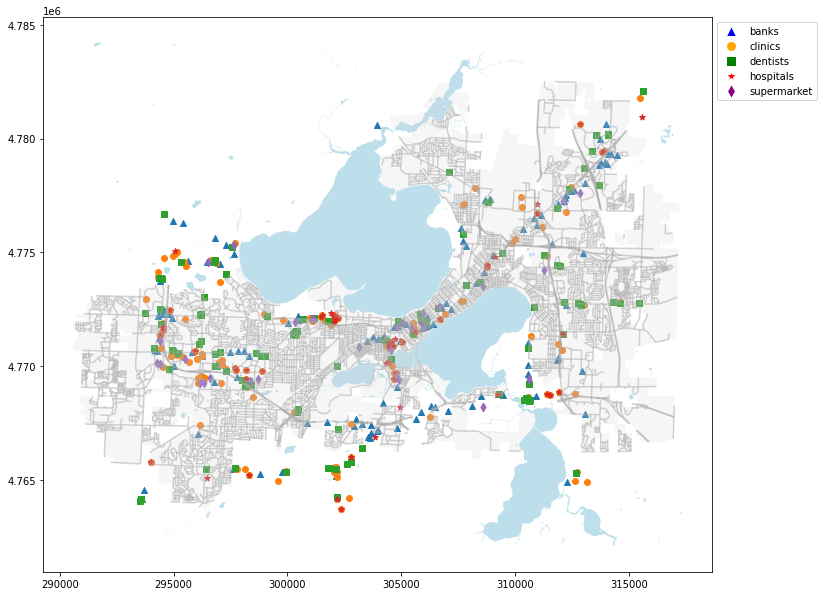

In [82]:
temp_df = services_gdf.apply(copy.deepcopy)
background_path = os.path.join('..', 'data', 'plot', 'background')
street = gpd.read_file(os.path.join(background_path, "street-meter-shp")).to_crs(4326)
max_lon = street.bounds.maxx.max()
min_lon = street.bounds.minx.min()
max_lat = street.bounds.maxy.max()
min_lat = street.bounds.miny.min()

gtfo = SCanalyzer(os.path.join('..', 'data', 'mmt_gtfs.zip'))
ax = plot_background(f"EPSG:{gtfo.epsg}")

epsg = findEPSG(temp_df['latitude'][0], temp_df['longitude'][0])
transformer = Transformer.from_crs(4326, epsg)
stop_x, stop_y = transformer.transform(
            temp_df['latitude'], temp_df['longitude'])
temp_df['stop_x'], temp_df['stop_y'] = stop_x, stop_y
temp_df = temp_df[(temp_df['latitude'] < max_lat) & (temp_df['latitude'] > min_lat) & (temp_df['longitude'] < max_lon) & (temp_df['longitude'] > min_lon)]
banks = temp_df[temp_df['service'] == 'banks']
clinics = temp_df[temp_df['service'] == 'clinics']
dentists = temp_df[temp_df['service'] == 'dentists']
hospitals = temp_df[temp_df['service'] == 'hospitals']
supermarket = temp_df[temp_df['service'] == 'supermarket']
banks = gpd.GeoDataFrame(
    banks['service'], geometry=gpd.points_from_xy(banks.stop_x, banks.stop_y), crs="EPSG:"+str(epsg))
clinics = gpd.GeoDataFrame(
    clinics['service'], geometry=gpd.points_from_xy(clinics.stop_x, clinics.stop_y), crs="EPSG:"+str(epsg))
dentists = gpd.GeoDataFrame(
    dentists['service'], geometry=gpd.points_from_xy(dentists.stop_x, dentists.stop_y), crs="EPSG:"+str(epsg))
hospitals = gpd.GeoDataFrame(
    hospitals['service'], geometry=gpd.points_from_xy(hospitals.stop_x, hospitals.stop_y), crs="EPSG:"+str(epsg))
supermarket = gpd.GeoDataFrame(
    supermarket['service'], geometry=gpd.points_from_xy(supermarket.stop_x, supermarket.stop_y), crs="EPSG:"+str(epsg))
banks.plot(ax=ax, marker='^')
clinics.plot(ax=ax, marker='o')
dentists.plot(ax=ax, marker='s')
hospitals.plot(ax=ax, marker='*')
r = supermarket.plot(ax=ax, marker='d')

lineslist = []
lineslist.append(lines.Line2D([],[],color="white", markerfacecolor = "blue", marker = "^", markersize=10, label = "banks"))
lineslist.append(lines.Line2D([],[],color="white", markerfacecolor = "orange", marker = "o", markersize=10, label = "clinics"))
lineslist.append(lines.Line2D([],[],color="white", markerfacecolor = "green", marker = "s", markersize=10, label = "dentists"))
lineslist.append(lines.Line2D([],[],color="white", markerfacecolor = "red", marker = "*", markersize=10, label = "hospitals"))
lineslist.append(lines.Line2D([],[],color="white", markerfacecolor = "purple", marker = "d", markersize=10, label = "supermarket"))
r.legend(handles = lineslist, bbox_to_anchor=(1.00, 1.00), loc="upper left",prop={"size": 10})

# AWS test

In [14]:
from SCanalyzer.busSim.manager import managerFactory
aws = managerFactory.create("aws", gtfs_path=None, city_path=None, out_path=None)

manager create
self=<SCanalyzer.busSim.manager.managerFactory.ManagerFactory object at 0x7f4824093a60>
key='aws'
manager=<class 'SCanalyzer.busSim.manager.AWSManager.AWSManager'>


TypeError: __init__() got an unexpected keyword argument 'city_path'

In [ ]:
aws.clean_up()

In [ ]:
import boto3
aws_lambda = boto3.client('lambda', region_name='ap-northeast-1')
with open("tmp.zip", 'rb') as f:
    response = aws_lambda.create_function(
        Code={
            'ZipFile': f.read()
        },
        Description='BusSim handler',
        FunctionName="test",
        Handler='lambda_function.lambda_handler',
        MemorySize=512,
        Publish=True,
        Role="arn:aws:iam::347664766527:role/s3rwRole",
        Runtime='python3.8',
        Timeout=900,
        TracingConfig={
            'Mode': 'Active',
        },
    )